In [44]:
import glob
import os
import json
import numpy as np
from scipy import linalg, stats, signal
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn.metrics as metrics
# from sklearn.pipeline import make_pipeline
# from sklearn.svm import LinearSVC, SVC
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
# from pyriemann.estimation import Covariances
# from pyriemann.tangentspace import TangentSpace
# from pyriemann.classification import TSclassifier, MDM, FgMDM
# from pyriemann.utils.mean import mean_covariance
from braindecode.datasets import BaseConcatDataset
from collections import defaultdict
from shutil import copyfile
from tqdm import tqdm
from data_util import load_subjects, load_subject_data, load_data, euclidean_alignment, label_alignment, np_standardize

In [2]:
data_dir = "../data/vin/Official/"
als_data_dir = "../data/vin/Official/"

In [85]:
%%time
# fmt: off
subjects = [
    'K299', 'K300', 
    'K309', 'K310', 'K311', 'K312', 'K313', 
    'K314', 'K315', 'K316', 'K319', 
    'K320', 'K321', 'K322', 'K323', 'K324', 
    'K325', 'K326', 'K327', 'K328', 'K329', 
    'K330', 'K331', 'K332', 'K333', 'K334', 
    'K335', 'K336', 'K337', 'K338', 'K339', 
    'K340', 'K342', 'K343', 'K344', 'K350', 
    'K351', 'K352', 'K353', 'K354', 'K355', 
    'K356', 'K357', 'K358', 'K359', 'K360', 
    'K361', 'K362', 'K363', 'K364', 'K365', 
    'K366', 'K367', 'K368', 'K369', 'K370', 
    'K371', 'K372', 'K373', 'K374', 'K375',
]

# subjects = [
#     'K300', 'K309', 'K311', 'K312', 'K313', 
#     'K314', 'K315', 'K316', 'K320', 'K321', 
#     'K322', 'K323', 'K324', 'K325', 'K327', 
#     'K328', 'K329', 'K332', 'K335', 'K336', 
#     'K337', 'K338', 'K339', 'K354', 'K355', 
#     'K358', 'K359', 'K360', 'K361', 'K362', 
#     'K364', 'K366', 'K368', 'K369', 'K370', 
#     'K371', 'K372', 'K373', 'K374', 'K375',
# ]

# use_k_subjects = True  # @param {"type": "boolean"}
# use_bn_subjects = False  # @param {"type": "boolean"}

# subjects = list()
# if use_k_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("K")])
# if use_bn_subjects:
#     subjects.extend([subject for subject in full_scenarios_subjects if subject.startswith("BN")])

subjects = sorted(subjects)

scenarios = [
    "nâng tay trái",
    "nâng tay phải",
    "nâng chân trái",
    "nâng chân phải",
    "gật đầu",
    "lắc đầu",
    "há miệng",
]

events = [
    "Thinking",
    # "Thinking and Acting",
    "Resting",
    # "Typing",
]

channels = [
    "Fp1", "Fp2",
    "F7", "F3", "Fz", "F4", "F8",
    "FT9", "FC5", "FC1", "FC2", "FC6", "FT10",
    "T7", "C3", "Cz", "C4", "T8",
    "CP5", "CP1", "CP2", "CP6",
    "P7", "P3", "Pz", "P4", "P8",
    "PO9", "O1", "Oz", "O2", "PO10",
]
# channels = [
#     # "F3", "Fz", "F4",
#     "FC5", "FC1", "FC2", "FC6",
#     "C3", "Cz", "C4",
#     "CP5", "CP1", "CP2", "CP6",
#     # "P3", "Pz", "P4",
# ]

label_mapping={
    "nâng tay trái_Thinking": "nâng tay trái",
    "nâng tay phải_Thinking": "nâng tay phải",
    "nâng chân trái_Thinking": "nâng chân trái",
    "nâng chân phải_Thinking": "nâng chân phải",
    "gật đầu_Thinking": "gật đầu",
    "lắc đầu_Thinking": "lắc đầu",
    "há miệng_Thinking": "há miệng",
    "nâng tay trái_Thinking and Acting": "nâng tay trái",
    "nâng tay phải_Thinking and Acting": "nâng tay phải",
    "nâng chân trái_Thinking and Acting": "nâng chân trái",
    "nâng chân phải_Thinking and Acting": "nâng chân phải",
    "gật đầu_Thinking and Acting": "gật đầu",
    "lắc đầu_Thinking and Acting": "lắc đầu",
    "há miệng_Thinking and Acting": "há miệng",
    "Resting": "rest",
}

n_channels = len(channels)

print(f"using {n_channels} channels")

minimal_trial_duration = 4  # @param
window_duration = 4  # @param
window_stride_duration = 4  # @param

fmin = 8.0  # @param
fmax = 30.0  # @param

# subjects.remove("K324")

ds = load_data(
    data_dir,  
    subjects=subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=-1,
    stop_offset=1,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

als_subjects = ["ALS01_t1", "ALS01_t2", "ALS02_t1", "ALS02_t2"]

als_ds = load_data(
    als_data_dir,  
    subjects=als_subjects,
    scenarios=scenarios,
    events=events,
    channels=channels,
    label_mapping=label_mapping,
    minimal_trial_duration=minimal_trial_duration,
    window_duration=window_duration, 
    window_stride_duration=window_stride_duration, 
    start_offset=0,
    stop_offset=0,
    fmin=fmin, 
    fmax=fmax, 
    moving_standardize=False,
    epoch_standardize=False,
    resample=None,
    return_raw=False,
    return_preprocessed=False,
    preload=True,
)

ds = BaseConcatDataset([ds, als_ds])

# fmt: on

for _ds in ds.datasets:
    _ds_info = _ds.description
    if _ds_info["subject"] == "K314":
        _ds_info["subject"] = "K314_t1"
    elif _ds_info["subject"] == "K324":
        _ds_info["subject"] = "K314_t2"

ds_info = ds.description

using 32 channels


subject:  36%|███▌      | 36/101 [00:00<00:00, 192.76it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  73%|███████▎  | 74/101 [00:05<00:02,  9.85it/s] /home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(f"{sample_dir}/EEG.edf", preload=False, verbose=False)
subject:  76%|███████▌  | 77/101 [00:05<00:02,  9.16it/s]/home/administrator/txdat/eeg-motor-imagery/notebooks/data_util.py:228: RuntimeWarning: Limited 1 annotation(s

CPU times: user 1min 31s, sys: 9.72 s, total: 1min 40s
Wall time: 1min 41s


In [10]:
dur = defaultdict(list)

for _ds in ds.datasets:
    _ds_anno = pd.DataFrame(_ds.raw.annotations)
    for _, r in _ds_anno.iterrows():
        dur[r["description"]].append(r["duration"])

/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

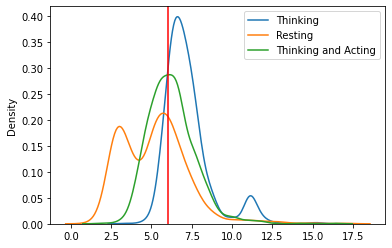

In [16]:
for k, v in dur.items():
    if k == "Typing":
        continue
    
    sb.distplot(v, hist=False, label=k)
    
plt.axvline(x=6, c='red')
    
plt.legend()

In [75]:
subject = "K309"
label = "nâng tay phải"

epochs = mne.concatenate_epochs([ds.datasets[i].windows for i in ds_info[(ds_info["subject"] == subject) & (ds_info["label"] == label)].index])
len(epochs)

3

In [76]:
epochs.get_data()[0].shape

(32, 768)

In [64]:
channel_id = {c: i for i, c in enumerate(channels)}
channel_id

{'Fp1': 0,
 'Fp2': 1,
 'F7': 2,
 'F3': 3,
 'Fz': 4,
 'F4': 5,
 'F8': 6,
 'FT9': 7,
 'FC5': 8,
 'FC1': 9,
 'FC2': 10,
 'FC6': 11,
 'FT10': 12,
 'T7': 13,
 'C3': 14,
 'Cz': 15,
 'C4': 16,
 'T8': 17,
 'CP5': 18,
 'CP1': 19,
 'CP2': 20,
 'CP6': 21,
 'P7': 22,
 'P3': 23,
 'Pz': 24,
 'P4': 25,
 'P8': 26,
 'PO9': 27,
 'O1': 28,
 'Oz': 29,
 'O2': 30,
 'PO10': 31}

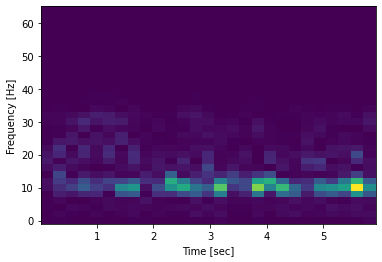

In [86]:
f, t, Sxx = signal.spectrogram(epochs.get_data()[0, channel_id["C3"]], fs=128.0, nperseg=32, nfft=64)

# print(f)
# print(t)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

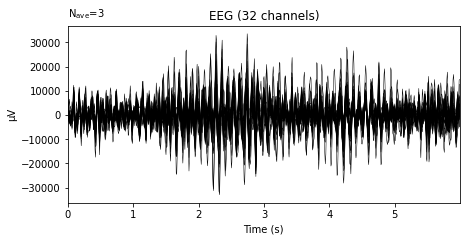

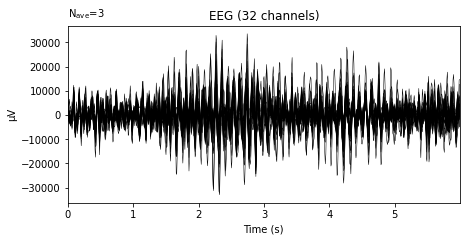

In [80]:
evoked = epochs.average()

evoked.plot()

In [81]:
freq_range = np.arange(4, 38)

power = mne.time_frequency.tfr_multitaper(epochs, freqs=freq_range, n_cycles=freq_range / 2.0, use_fft=True,
                                          return_itc=False, average=True, decim=2)

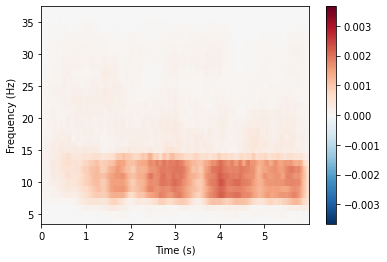

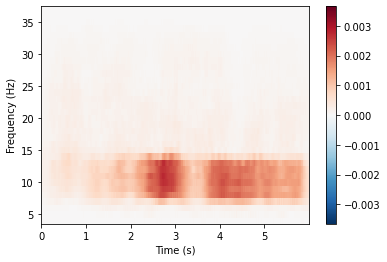

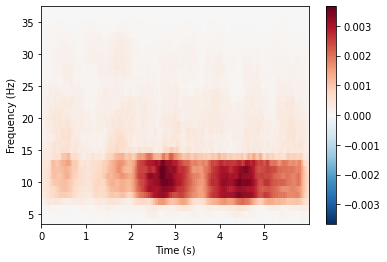

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [84]:
power.plot(["C3", "Cz", "C4"])

/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/administrator/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

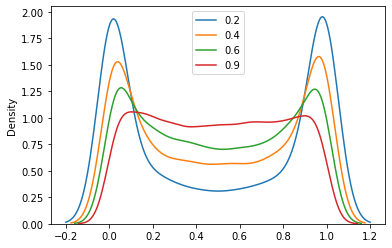

In [89]:
rng = np.random.RandomState(seed=42)

for alpha in [0.2, 0.4, 0.6, 0.9]:
    sb.distplot(rng.beta(alpha, alpha, 10000), hist=False, label=alpha)
    
plt.legend()